In [1]:
from fourlang.text_to_4lang import TextTo4lang
from graphviz import Source
from scripts.parse_data import read_sherliic, build_graph

from tqdm import tqdm

text_to_4lang = TextTo4lang(lang="en")
data = read_sherliic("data/dev.csv", ud_path="data/relation_index.tsv", keep_context=True)
data_frame = build_graph(data)

## ID-s where we found the entailment

In [2]:
6
11
21
29
31
37
45
47
57
59
60
66
70
79
82
83
89
90
94
99
117
134
140
167
180
183
187
190
198
200
202
217
240
282
288
304
307
340
346
360
374
385
419
436
479
495
496
501
506
527
532
536
537
538
564
576
589
592
595
613
642
654
672
697
726
742
747
758
773
774
783
826
828
829
830
833
836
858
904
907
921
925
938
954
957
973
975
979
984

984

In [9]:
import math
import re

def clear_node(node):
    """
    Clears the node from the 4lang id parts
    :param node: the text to clear
    :return: the cleared text
    """
    return re.sub(r'_[0-9][0-9]*', '', node)

def asim_jac_edges(graph_premise, graph_hypothesis):
    """
    Asymmetric Jaccard similarity between the edges of the definition graphs
    :param graph_premise: the definition graph of the premise
    :param graph_hypothesis: the definition graph of the hypothesis
    :return: the ratio of overlapping edges per the length of the hypothesis definition
    """
    prem = set([(clear_node(s), clear_node(r), e['color'])
                for (s, r, e) in graph_premise.G.edges(data=True)])
    hyp = set([(clear_node(s), clear_node(r), e['color'])
               for (s, r, e) in graph_hypothesis.G.edges(data=True)])
    
    hyp_cleared = []
    for triplet in hyp:
        if triplet[0] != "A" and  triplet[0] != "B" and triplet[1] != "A" and triplet[1] != "B":
            hyp_cleared.append(triplet)
            
    hyp = set(hyp_cleared)
    sim = hyp & prem
    print(sim)
    if not sim or len(hyp) == 0:
        return 0
    else:
        #return float(len(sim)) / math.sqrt(len(hyp))
        #return len(sim)
        return float(len(sim)) / len(hyp)

In [109]:
index = 183
data.iloc[index]

prem_argleft                                                     A
premise                                             is currency in
prem_argright                                                    B
hypo_argleft                                                     A
hypothesis                                  is unit of currency of
hypo_argright                                                    B
score                                                            1
premise_ud                     nsubj___currency___prep___in___pobj
hypothesis_ud    nsubj^-___unit___prep___of___pobj___currency__...
Name: 183, dtype: object

In [114]:
# the method we used, printing out the found edges, it's the DEFAULT method, without using synonyms
graph_premise = text_to_4lang.process_deps(data_frame.iloc[index]["premise"], method="expand", depth=2, blacklist=["in", "on", "of"], filt=False, black_or_white="")
graph_hypothesis = text_to_4lang.process_deps(data_frame.iloc[index]["hypothesis"], method="expand", depth=1, blacklist=["in", "on", "of"], filt=False, black_or_white="")
pred = asim_jac_edges(graph_premise, graph_hypothesis)
print(pred)

{('currency', 'money', 0), ('facilitate', 'transaction', 2), ('use', 'facilitate', 0), ('item', 'other', 0)}
0.5


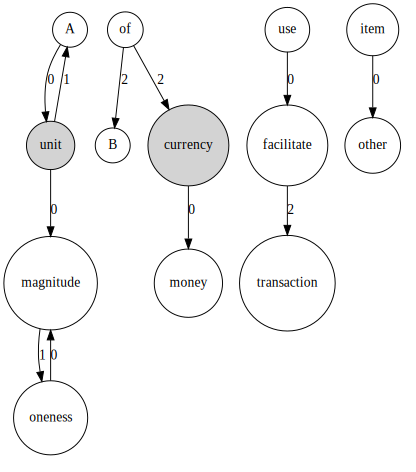

In [113]:
# look at the graphs
Source(graph_hypothesis.to_dot())

In [103]:
text_to_4lang.get_definition("trail")

'To follow behind (someone or something); to tail (someone or something).'

## Examples of finding entailment

These are examples, where the expand method was needed

* 975 -> B is signing treaty with A ; B has agreement with A ;

    treaty: 'A binding agreement concluded by subjects of international law, namely states and international organizations.'

    {('agreement', 'understanding', 0), ('course', 'specific', 0), ('understanding', 'entity', 0), ('follow', 'course', 2)}



* 925 -> B is having control of A ; B has influence in A ;

    influence: 'The power to affect, control or manipulate something or someone; the ability to change the development of fluctuate,fluctuating things such as conduct, thoughts or decisions.'

    {('control', 'something', 2), ('thing', 'conduct', 0), ('development', 'thing', 0), ('ability', 'something', 0), ('influence', 'power', 0), ('something', 'ability', 0), ('thing', 'fluctuating', 0), ('change', 'development', 2)}


* 826 -> B is granting to A ; B is giving to A

    grant: 'to give (permission or wish)'

    {('something', 'somewhere', 0), ('provide', 'something', 2), ('give', 'move', 0), ('something', 'abstract', 0)}
    

* 783 -> A is helping B ; A is giving to B ;

    help: Action given to provide assistance; aid.

    {('something', 'somewhere', 0), ('provide', 'something', 2), ('give', 'move', 0), ('something', 'abstract', 0)}


* 672 -> A is being assassinated in B ; A is murdered in B

    assassinate: 'To murder someone, especially an important person, by a sudden or obscure attack, especially for ideological or political reasons.'

    {('act', 'human', 0), ('human', 'especially', 0), ('murder', 'act', 0), ('human', 'act', 0)}


* 536 -> A is trailing B ; A is behind B ;

    trail: To follow behind (someone or something); to tail (someone or something).
    
    {('back', 'of', 0), ('something', 'else', 0), ('behind', 'position', 0)}


An error made by the UD parser?

* 167 -> A  is being born in town of B ; A is being born at B 

    pobj^-___at___prep^-___bear___nsubjpass

    bear??


Simpler case, where basically the two share a common word, more can be found with the id's above

* 183 -> A is currency in B ; A is unit of currency of B
    {('currency', 'money', 0), ('facilitate', 'transaction', 2), ('use', 'facilitate', 0), ('item', 'other', 0)}